In [ ]:
#Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import numpy as np
import tensorflow
import tensorflow as tf
import keras
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras import datasets, layers, models
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from scipy import signal

In [ ]:
#Loading Image Data
with zipfile.ZipFile("Group21_Assignment3.zip","r") as zip_ref:
    zip_ref.extractall()
zip_ref.close()

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = plt.imread(os.path.join(folder,filename))
        dim = img.shape
        if len(dim)!=3: #Grayscale image
          img = np.array([img.T,img.T,img.T]).T
        
        img   = tensorflow.image.resize(img,size = (224,224),
        method=tensorflow.image.ResizeMethod.BILINEAR,preserve_aspect_ratio=False)
      
        if img is not None:
            images.append(np.array(img))
    return images

#**`Dataset`**

In [ ]:
#Train Data
train_butterfly = np.array(load_images_from_folder("Group_21/train/butterfly"))
train_kangaroo  = np.array(load_images_from_folder("Group_21/train/kangaroo"))
train_sunflower = np.array(load_images_from_folder("Group_21/train/sunflower"))

x_train = np.concatenate([train_butterfly,train_kangaroo,train_sunflower])
y_train = np.concatenate([0+np.zeros(len(train_butterfly)),1+np.zeros(len(train_kangaroo)),
                          2+np.zeros(len(train_sunflower))])
                          
#Validation Data
val_butterfly = np.array(load_images_from_folder("Group_21/val/butterfly"))
val_kangaroo  = np.array(load_images_from_folder("Group_21/val/kangaroo"))
val_sunflower = np.array(load_images_from_folder("Group_21/val/sunflower"))

x_val = np.concatenate([val_butterfly,val_kangaroo,val_sunflower])
y_val = np.concatenate([0+np.zeros(len(val_butterfly)),1+np.zeros(len(val_kangaroo)),
                          2+np.zeros(len(val_sunflower))])
     
#Test Data
test_butterfly = np.array(load_images_from_folder("Group_21/test/butterfly"))
test_kangaroo  = np.array(load_images_from_folder("Group_21/test/kangaroo"))
test_sunflower = np.array(load_images_from_folder("Group_21/test/sunflower"))

x_test = np.concatenate([test_butterfly,test_kangaroo,test_sunflower])
y_test = np.concatenate([0+np.zeros(len(test_butterfly)),1+np.zeros(len(test_kangaroo)),
                          2+np.zeros(len(test_sunflower))])

del train_butterfly,train_kangaroo,train_sunflower
del val_butterfly,val_kangaroo,val_sunflower
del test_butterfly,test_kangaroo,test_sunflower

#Normalizing Input
x_train,x_val,x_test = x_train/255,x_val/255,x_test/255

# **`Q1`**

Convolutional Filter:
 [[ 0.06936  0.35645  0.34802]
 [-0.51588 -0.1451   0.17654]
 [ 0.52891 -1.04378  0.8723 ]]


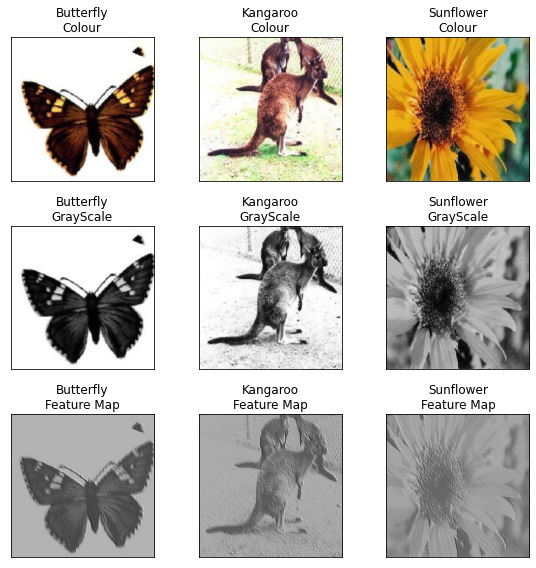

Expected dimension of feature map:	 (222, 222)
Dimension of feature map obtained:	 (222, 222)


In [ ]:
np.random.seed(2500)
for i in set(y_train):                                  
  index = list(range(len(y_train[y_train==i])))
  np.random.shuffle(index)
img_butterfly_colour = x_train[y_train==0][index[0]]
img_kangaroo_colour  = x_train[y_train==1][index[0]]
img_sunflower_colour = x_train[y_train==2][index[0]]

#Grayscale 
def Colour_to_GrayScale(IMG):
  return (0.2989*IMG.T[0] + 0.5870*IMG.T[1] + 0.1140*IMG.T[2]).T

img_butterfly = Colour_to_GrayScale(img_butterfly_colour)
img_kangaroo  = Colour_to_GrayScale(img_kangaroo_colour)
img_sunflower = Colour_to_GrayScale(img_sunflower_colour)

def Plot_Image(nrows,ncols,index,IMG,title,gray=True):
  #IMG = np.clip(a = IMG, a_min = 0, a_max = 1)
  plt.subplot(nrows,ncols,index)
  if gray:  plt.imshow(IMG,cmap='gray')
  else:     plt.imshow(IMG)
  plt.xticks([]);plt.yticks([])
  plt.title(title)

plt.figure(figsize=(8,8))
Plot_Image(nrows=3,ncols=3,index=1,IMG=img_butterfly_colour,title='Butterfly\nColour')
Plot_Image(nrows=3,ncols=3,index=2,IMG=img_kangaroo_colour, title='Kangaroo\nColour')
Plot_Image(nrows=3,ncols=3,index=3,IMG=img_sunflower_colour,title='Sunflower\nColour')

Plot_Image(nrows=3,ncols=3,index=4,IMG=img_butterfly,title='Butterfly\nGrayScale')
Plot_Image(nrows=3,ncols=3,index=5,IMG=img_kangaroo, title='Kangaroo\nGrayScale')
Plot_Image(nrows=3,ncols=3,index=6,IMG=img_sunflower,title='Sunflower\nGrayScale')

convolutional_filter = np.random.normal(loc=0,scale=np.sqrt(2/3**2),size=(3,3))
print("Convolutional Filter:\n",np.around(convolutional_filter,5))

S = 1 #Stride
P = 0 #Padding
def Conv2D(a, f):
    s = f.shape + tuple(np.subtract(a.shape, f.shape) + 1)
    strd = np.lib.stride_tricks.as_strided
    subM = strd(a, shape = s, strides = a.strides * 2)
    return np.einsum('ij,ijkl->kl', f, subM)

conv_butterfly = Conv2D(img_butterfly,convolutional_filter)
conv_kangaroo  = Conv2D(img_kangaroo, convolutional_filter)
conv_sunflower = Conv2D(img_sunflower,convolutional_filter)

Plot_Image(nrows=3,ncols=3,index=7,IMG=conv_butterfly,title='Butterfly\nFeature Map')
Plot_Image(nrows=3,ncols=3,index=8,IMG=conv_kangaroo, title='Kangaroo\nFeature Map')
Plot_Image(nrows=3,ncols=3,index=9,IMG=conv_sunflower,title='Sunflower\nFeature Map')
plt.tight_layout()
plt.show()

W1,H1 = img_butterfly.shape
F1,F2 = convolutional_filter.shape
W2    = int((W1-F1+2*P)/S + 1)
H2    = int((H1-F2+2*P)/S + 1)
print("Expected dimension of feature map:\t",(W2,H2))
print("Dimension of feature map obtained:\t",conv_butterfly.shape)


# **`Q2`**

In [ ]:
class Convolutional_Layer:
  def __init__(self,Image,f1,f2):
    self.S = 1 #Stride
    self.P = 0 #Padding
    self.Image = Image
    #np.random.seed(50)
    self.Filter1    =  np.random.normal(loc=0,scale=np.sqrt(2/3**2)     ,size=(f1,3,3))
    self.Filter2    =  np.random.normal(loc=0,scale=np.sqrt(2/(3**2*32)),size=(f2,3,3))
  
  def Conv2D(self,a, f):
    s = f.shape + tuple(np.subtract(a.shape, f.shape) + 1)
    strd = np.lib.stride_tricks.as_strided
    subM = strd(a, shape = s, strides = a.strides * 2)
    return np.einsum('ij,ijkl->kl', f, subM)
  
  def ReLU(self,IMG):
    IMG[IMG<0] = 0 
    return IMG
 
  def Plot_Image(self,nrows,ncols,index,IMG,title):
    #IMG = np.clip(a = IMG, a_min = 0, a_max = 1)
    plt.subplot(nrows,ncols,index)
    plt.imshow(IMG,cmap='gray')  
    plt.xticks([]);plt.yticks([])
    plt.title(title)
  
  def Layer1(self):
    Image1 = []
    for i in range(len(self.Filter1)):
      Image1.append(self.Conv2D(self.Image,self.Filter1[i]))
    Image1 = self.ReLU(np.array(Image1))

    #Index = list(range(len(Image1)))
    #np.random.shuffle(Index)
    plt.figure(figsize=(8,8))
    plt.suptitle("Layer 1",fontweight="bold",y=1+1e-2)
    index = 1
    for i in range(10):
      self.Plot_Image(nrows=4,ncols=5,index=index,IMG=self.Filter1[i],title="Filter "+str(i+1))
      self.Plot_Image(nrows=4,ncols=5,index=index+10,IMG=Image1[i],title="Filter Map "+str(i+1))
      index+=1
    plt.tight_layout()
    plt.show()
    return Image1
  
  def Layer2(self):
    Image1 = self.Layer1()

    Image2 = []
    for i in range(len(self.Filter2)):
      Img = 0
      for j in range(len(Image1)):
        Img += self.Conv2D(Image1[j],self.Filter2[i])
      Image2.append(Img)
    Image2 = self.ReLU(np.array(Image2))

    #Index = list(range(len(Image2)))
    #np.random.shuffle(Index)
    plt.figure(figsize=(8,8))
    plt.suptitle("Layer 2",fontweight="bold",y=1+1e-2)
    index = 1
    for i in range(10):
      self.Plot_Image(nrows=4,ncols=5,index=index,IMG=self.Filter2[i],title="Filter "+str(i+1))
      self.Plot_Image(nrows=4,ncols=5,index=index+10,IMG=Image2[i],title="Filter Map "+str(i+1))
      index+=1
    plt.tight_layout()
    plt.show()

    print("Layer 1:")
    W1,H1 = self.Image.shape
    F1,F2 = self.Filter1[0].shape
    W2    = int((W1-F1+2*P)/S + 1)
    H2    = int((H1-F2+2*P)/S + 1)
    print("Expected dimension of feature map:\t",(W2,H2))
    print("Dimension of feature map obtained:\t",Image1[0].shape)

    print("\nLayer 2:")
    W1,H1 = Image1[0].shape
    F1,F2 = self.Filter2[0].shape
    W2    = int((W1-F1+2*P)/S + 1)
    H2    = int((H1-F2+2*P)/S + 1)
    print("Expected dimension of feature map:\t",(W2,H2))
    print("Dimension of feature map obtained:\t",Image2[0].shape)
    #return Image2

Butterfly:



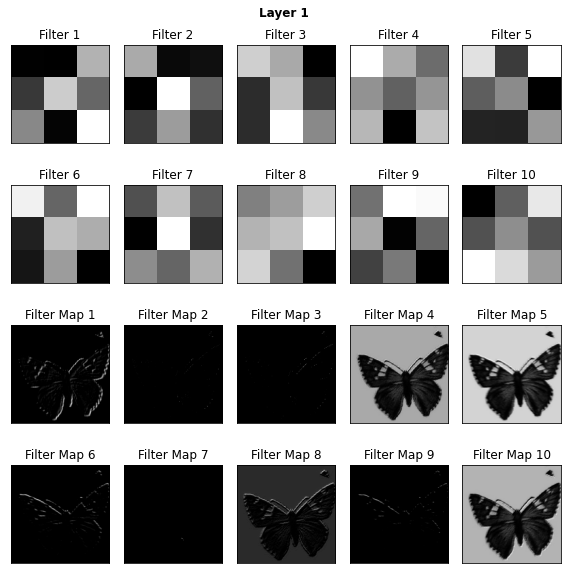

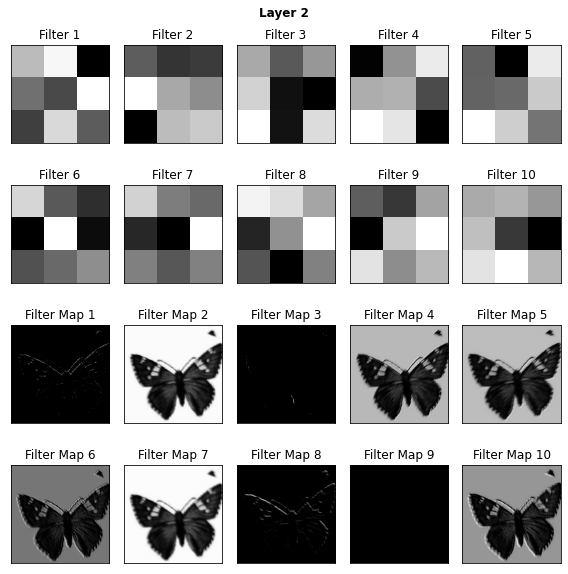

Layer 1:
Expected dimension of feature map:	 (222, 222)
Dimension of feature map obtained:	 (222, 222)

Layer 2:
Expected dimension of feature map:	 (220, 220)
Dimension of feature map obtained:	 (220, 220)

Kangaroo:



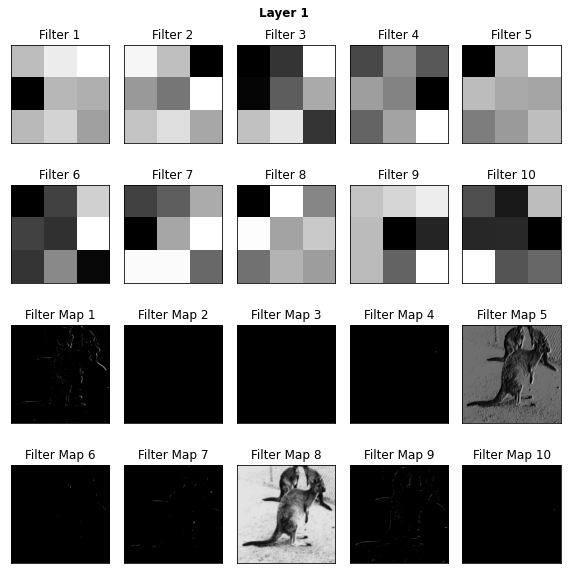

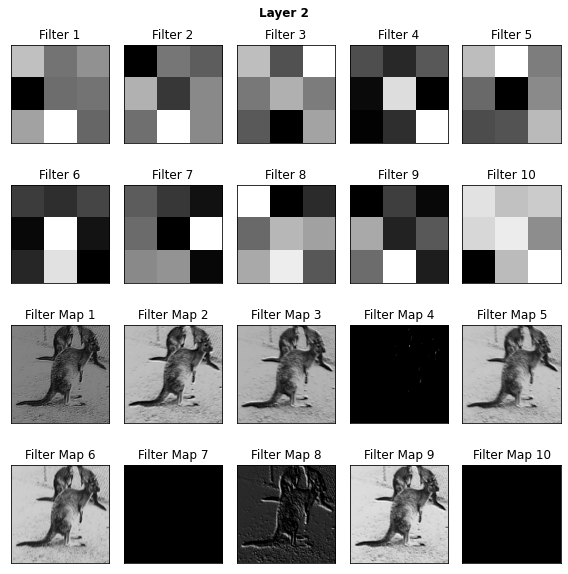

Layer 1:
Expected dimension of feature map:	 (222, 222)
Dimension of feature map obtained:	 (222, 222)

Layer 2:
Expected dimension of feature map:	 (220, 220)
Dimension of feature map obtained:	 (220, 220)

Sunflower:



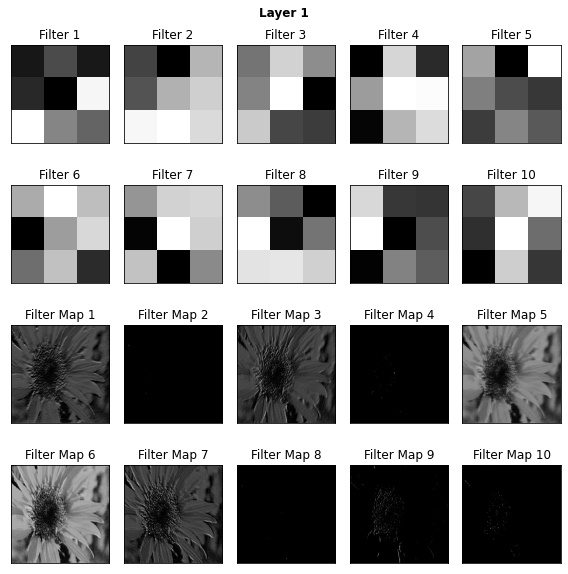

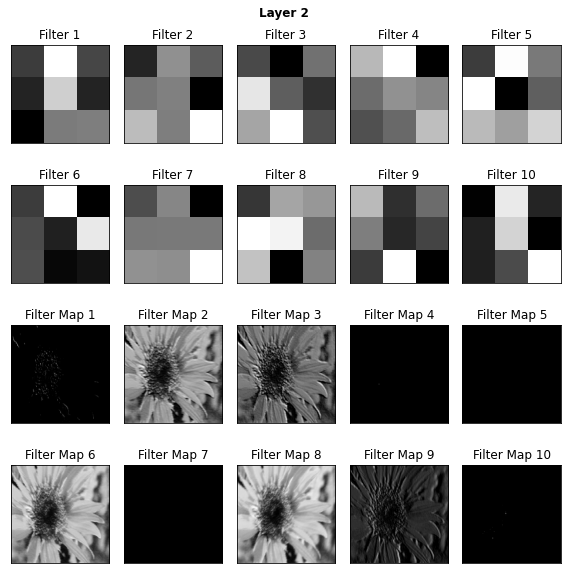

Layer 1:
Expected dimension of feature map:	 (222, 222)
Dimension of feature map obtained:	 (222, 222)

Layer 2:
Expected dimension of feature map:	 (220, 220)
Dimension of feature map obtained:	 (220, 220)


In [ ]:
print("Butterfly:\n")
Butterfly = Convolutional_Layer(Image=img_butterfly,f1=32,f2=64)
Butterfly.Layer2()

print("\nKangaroo:\n")
Kangaroo = Convolutional_Layer(Image=img_kangaroo,f1=32,f2=64)
Kangaroo.Layer2()

print("\nSunflower:\n")
Sunflower = Convolutional_Layer(Image=img_sunflower,f1=32,f2=64)
Sunflower.Layer2()

# **`Q3`**

In [ ]:
#Converting one hot encoded test label to label
def ohetolabel(array): 
  output = list()
  for i in range(len(array)):
    output.append(np.argmax(array[i]))
  return np.array(output)
  
#Plot cf matrix
def cf_matrix_plot(cf_matrix,title):
  #group_names = ['True Neg','False Pos','False Neg','True Pos','True Pos','True Pos','True Pos','True Pos','True Pos']

  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]

  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

  labels = [f"{v1}\n{v2}\n" for v1, v2 in
            zip(group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(3,3)

  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

  ax.set_title(title);
  ax.set_xlabel('\nPredicted Image Class')
  ax.set_ylabel('Actual Image Class');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['Butterfly','Kangaroo','Sunflower'])
  ax.yaxis.set_ticklabels(['Butterfly','Kangaroo','Sunflower'])

In [ ]:
def CNN(x_train,x_val,x_test,y_train,y_val,y_test):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3),kernel_initializer = tf.keras.initializers.HeNormal()))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_initializer = tf.keras.initializers.HeNormal())) 
  model.add(layers.MaxPooling2D((2, 2)))


  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu',kernel_initializer = tf.keras.initializers.LecunNormal()))
  model.add(layers.Dense(3,  activation='softmax',kernel_initializer = tf.keras.initializers.LecunNormal()))

  tensorflow.keras.optimizers.SGD(learning_rate=0.01)
  model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  ohe = OneHotEncoder()
  y_train = ohe.fit_transform(y_train.reshape(-1,1)).toarray()
  y_val = ohe.fit_transform(y_val.reshape(-1,1)).toarray()
  y_test = ohe.fit_transform(y_test.reshape(-1,1)).toarray()
  
  error_th = 1e-4
  es = EarlyStopping(monitor='loss',mode='min',min_delta = error_th,verbose=0,patience=2)
  history = model.fit(x_train, y_train, epochs=100,batch_size=1,verbose=0, 
                    validation_data=(x_val, y_val),callbacks=[es])

  # this is for prediction purpose
  y_train_pred = model.predict(x_train)
  y_val_pred   = model.predict(x_val)
  y_test_pred  = model.predict(x_test)

  y_train      = ohetolabel(y_train)
  y_val        = ohetolabel(y_val)
  y_test       = ohetolabel(y_test)
  y_train_pred = ohetolabel(y_train_pred)
  y_val_pred   = ohetolabel(y_val_pred)
  y_test_pred  = ohetolabel(y_test_pred)

  print("No of Epochs =",len(history.history["loss"]))
  plt.figure(figsize=(12.5,8))
  plt.suptitle('CNN',fontweight="bold",y=1+1e-2)
  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'],marker='.')
  plt.plot(history.history['val_accuracy'],marker='.')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid()
  
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'],marker='.')
  plt.plot(history.history['val_loss'],marker='.')
  plt.title('Model loss') 
  plt.ylabel('Loss') 
  plt.xlabel('Epoch') 
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid()
  plt.tight_layout();plt.show()

  print("Training Accuracy =\t",history.history['accuracy'][-1])
  print("Validation Accuracy =\t",history.history['val_accuracy'][-1])

  #Generate the confusion matrix
  plt.figure(figsize=(12.5,4))
  plt.suptitle('CNN',fontweight="bold",y=1+1e-2)
  plt.subplot(1,3,1)
  cf_matrix = confusion_matrix(y_train, y_train_pred)
  cf_matrix_plot(cf_matrix,"Training Data")
  
  plt.subplot(1,3,2)
  cf_matrix = confusion_matrix(y_val, y_val_pred)
  cf_matrix_plot(cf_matrix,"Validation Data")

  plt.subplot(1,3,3)
  cf_matrix = confusion_matrix(y_test, y_test_pred)
  cf_matrix_plot(cf_matrix,"Test Data")  
  plt.tight_layout()
  plt.show()

  print("\tTraining Data\t\t\t\tValidation Data\t\t\t\tTest Data")
  print("Accuracy:",end=" ")
  print(np.around(accuracy_score(y_train , y_train_pred),4),end="\t"*4)
  print(np.around(accuracy_score(y_val , y_val_pred),4),end="\t"*5)
  print(np.around(accuracy_score(y_test , y_test_pred),4))

  print("Precision:",end="")
  print(np.around(precision_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
  print(np.around(precision_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
  print(np.around(precision_score(y_test , y_test_pred,average="macro"),4))

  print("Recall:",end="   ")
  print(np.around(recall_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
  print(np.around(recall_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
  print(np.around(recall_score(y_test , y_test_pred,average="macro"),4))

  print("F1-Score:",end=" ")
  print(np.around(f1_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
  print(np.around(f1_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
  print(np.around(f1_score(y_test , y_test_pred,average="macro"),4))

  return model

In [ ]:
def one_hot_encoding(input):
  output = []
  for i in input:
    tmp = [0,0,0]
    tmp[int(i)] = 1
    output.append(tmp)
  return np.asarray(output).reshape(-1,3,1)
  
def binary_cross_entropy(y_true, y_pred):
    e = 1e-5
    return np.mean(-y_true * np.log(y_pred + e) - (1 - y_true) * np.log(1 - y_pred + e))

def binary_cross_entropy_prime(y_true, y_pred):
    e = 1e-5
    return ((1 - y_true) / (1 - y_pred + e) - y_true / (y_pred + e)) / np.size(y_true)

def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output
fac = 1
def cnn(network, loss, loss_prime, x_train, y_train, x_val, y_val, x_test, y_test, epochs = 1000, learning_rate = 0.01, verbose = True):
    global fac
    for e in range(epochs):
        error = 0
        y_train_pred = []
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)
            y_train_pred.append(np.argmax(output))
            
            # error
            error += binary_cross_entropy(y, output)
            
            # backward
            grad = binary_cross_entropy_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)
            
        
        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error:\t{error}",end='\t\t') 
            y_train_pred = np.array(y_train_pred)
            print('acc:\t',sum(np.argmax(y_train,axis=1).reshape(y_train_pred.shape)==y_train_pred)/len(y_train))
    
    y_train_pred = []
    y_val_pred   = []
    y_test_pred  = []
    for x, y in zip(x_train, y_train):
        output = predict(network, x)  
        y_train_pred.append(np.argmax(output))
    for x, y in zip(x_val, y_val):
        output = predict(network, x)  
        y_val_pred.append(np.argmax(output))
    for x, y in zip(x_test, y_test):
        output = predict(network, x)  
        y_test_pred.append(np.argmax(output))

    y_train = np.argmax(y_train,axis=1).reshape(-1)
    y_val = np.argmax(y_val,axis=1).reshape(-1)
    y_test = np.argmax(y_test,axis=1).reshape(-1)
 
    #Generate the confusion matrix
    plt.figure(figsize=(12.5,4))
    plt.suptitle('VGG19',fontweight="bold",y=1+1e-2)
    plt.subplot(1,3,1)
    cf_matrix = confusion_matrix(y_train, y_train_pred)
    cf_matrix_plot(cf_matrix,"Training Data")
    
    plt.subplot(1,3,2)
    cf_matrix = confusion_matrix(y_val, y_val_pred)
    cf_matrix_plot(cf_matrix,"Validation Data")

    plt.subplot(1,3,3)
    cf_matrix = confusion_matrix(y_test, y_test_pred)
    cf_matrix_plot(cf_matrix,"Test Data")  
    plt.tight_layout()
    plt.show()

    print("\tTraining Data\t\t\t\tValidation Data\t\t\t\tTest Data")
    print("Accuracy:",end=" ")
    print(np.around(accuracy_score(y_train , y_train_pred),4),end="\t"*4)
    print(np.around(accuracy_score(y_val , y_val_pred),4),end="\t"*5)
    print(np.around(accuracy_score(y_test , y_test_pred),4))

    print("Precision:",end="")
    print(np.around(precision_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
    print(np.around(precision_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
    print(np.around(precision_score(y_test , y_test_pred,average="macro"),4))

    print("Recall:",end="   ")
    print(np.around(recall_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
    print(np.around(recall_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
    print(np.around(recall_score(y_test , y_test_pred,average="macro"),4))

    print("F1-Score:",end=" ")
    print(np.around(f1_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
    print(np.around(f1_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
    print(np.around(f1_score(y_test , y_test_pred,average="macro"),4))

class Reshape_Layer:
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)


class Relu_Layer:
    def __init__(self):
        pass

    def forward(self, input):
        self.input = input 
        return np.maximum(self.input,0)

    def backward(self, output_gradient, learning_rate):
        
        tmp = self.input > 0
        return np.multiply(output_gradient, tmp) 

class Softmax_Layer:

    def forward(self, input):
        tmp = np.exp(input-max(input))
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)

class Dense_Layer:
    def __init__(self, input_size, output_size):
        self.weights = np.random.normal(loc=0.0, scale=np.sqrt(1/input_size), size=(output_size, input_size))
        self.bias    = np.random.normal(loc=0.0, scale=np.sqrt(1/input_size), size=(output_size, 1))
        
    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

class MaxPool:
    def iterate_regions(self, image):
        _, h, w,  = image.shape
        
        new_h = h // 2
        new_w = w // 2
        
        for i in range(new_h):
            for j in range(new_w):
                im_region = image[:,(i*2):(i*2+2), (j*2):(j*2+2)]
                yield im_region, i, j
                
    def forward(self, input):
        
        self.last_input = input
        num_filters, h, w, = input.shape
        output = np.zeros((num_filters, h//2, w//2))
        
        for im_region, i, j in self.iterate_regions(input):
            output[:,i,j] = np.amax(im_region.T,axis=(0,1)) 
        return output
    
    def backward(self, d_l_d_out, learning_rate):
        
        d_l_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            f, h, w = im_region.shape
            amax = np.amax(im_region.T, axis=(0,1))
            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        #if the pixel was the max value, copy the gradient to it
                        if(im_region[f2,i2,j2] == amax[f2]):
                            d_l_d_input[f2, i*2+i2, j*2+j2] = d_l_d_out[f2, i, j]
                            break;
        return d_l_d_input

class Convolutional_Layer:
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.normal(loc=0.0, scale=np.sqrt(2/self.kernels_shape[0]*self.kernels_shape[1]*self.kernels_shape[2]), size=self.kernels_shape)
        self.biases  = np.random.normal(loc=0.0, scale=np.sqrt(2/self.kernels_shape[0]*self.kernels_shape[1]*self.kernels_shape[2]), size=self.output_shape)
        
    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)

        for i in range(self.depth):
            for j in range(self.input_depth):  
              self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        self.output = self.output 
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient   = np.zeros(self.input_shape)
        
        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j],output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient


# neural network
network = [
    Convolutional_Layer(input_shape = (3, 224, 224), kernel_size = 3, depth = 32),
    Relu_Layer(),
    
    Convolutional_Layer(input_shape = (32, 222, 222), kernel_size = 3, depth = 64),
    Relu_Layer(),
    MaxPool(),

    Reshape_Layer(input_shape = (64, 110, 110), output_shape = (64 * 110 * 110, 1)),
    Dense_Layer(input_size = 64 * 110 * 110, output_size = 128),
    Relu_Layer(),
    
    Dense_Layer(input_size = 128, output_size = 3),
    Softmax_Layer()
]

No of Epochs = 5


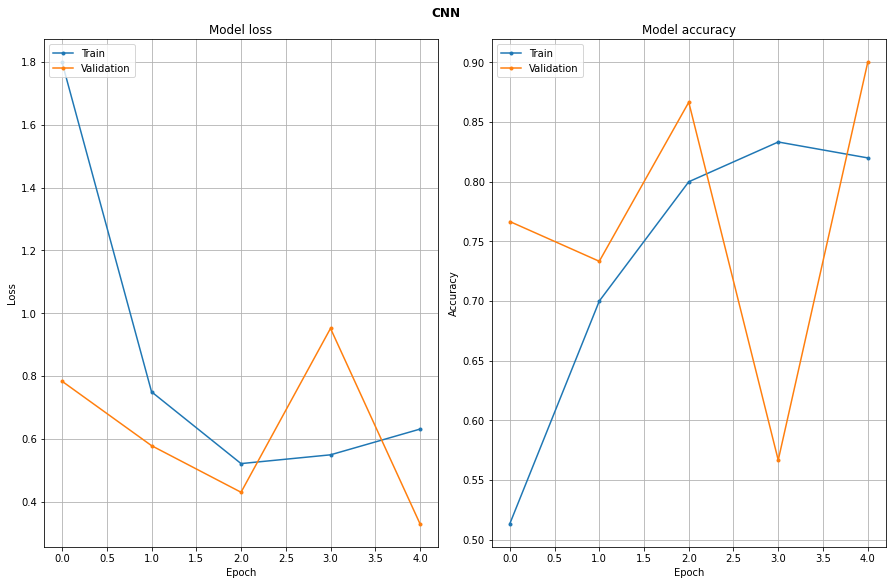

Training Accuracy =	 0.8199999928474426
Validation Accuracy =	 0.8999999761581421


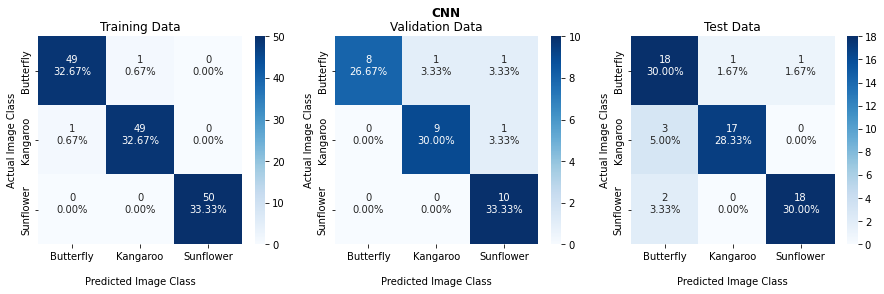

	Training Data				Validation Data				Test Data
Accuracy: 0.9867				0.9					0.8833
Precision:0.9867				0.9111					0.8915
Recall:   0.9867				0.9					0.8833
F1-Score: 0.9867				0.8993					0.885


In [ ]:
cnn = CNN(x_train,x_val,x_test,y_train,y_val,y_test)

Butterfly:


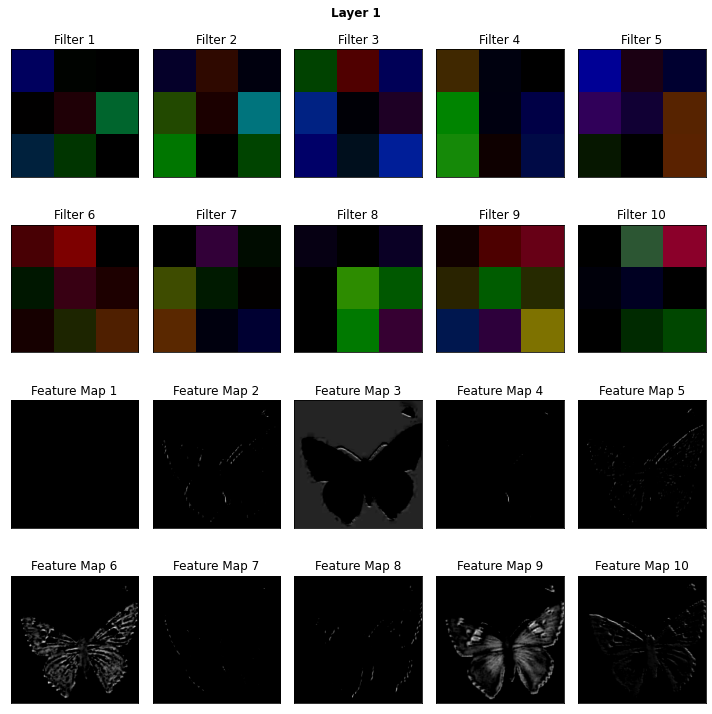

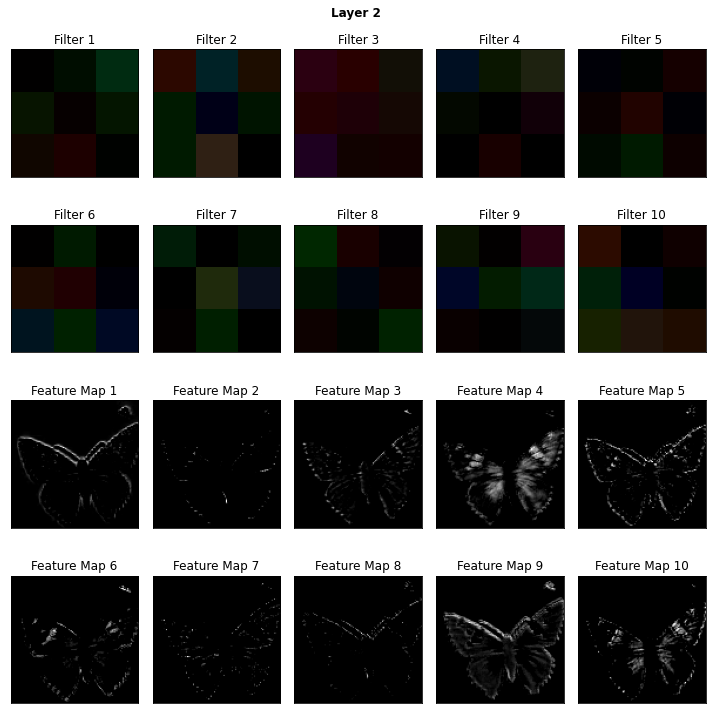


Kangaroo:


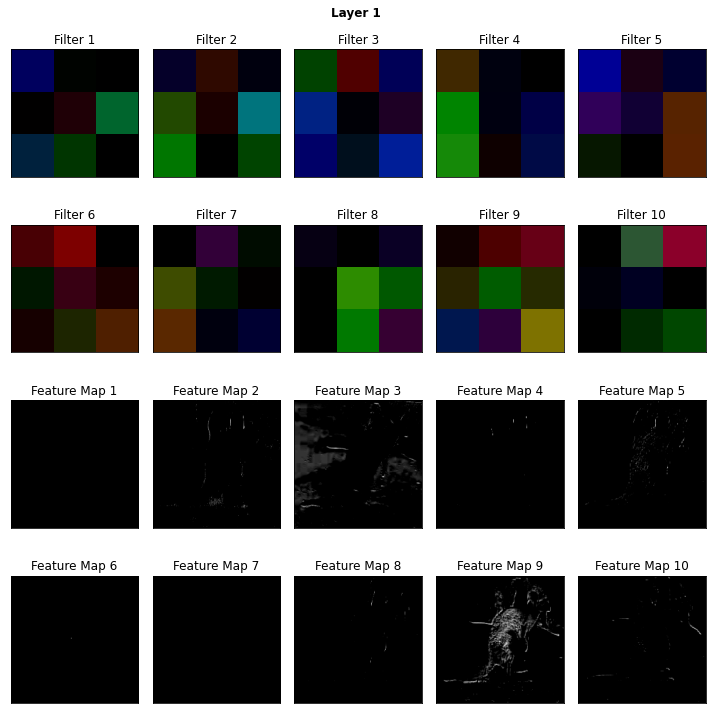

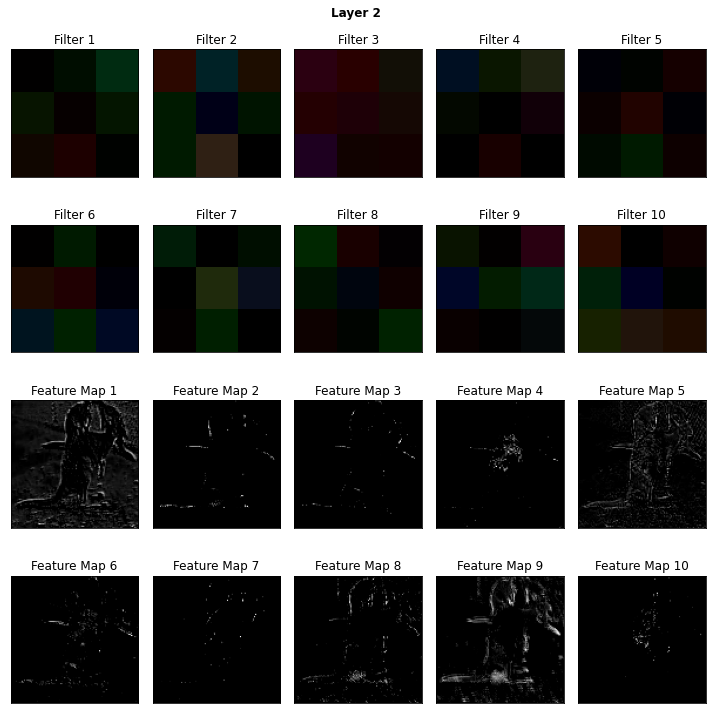


Sunflower:


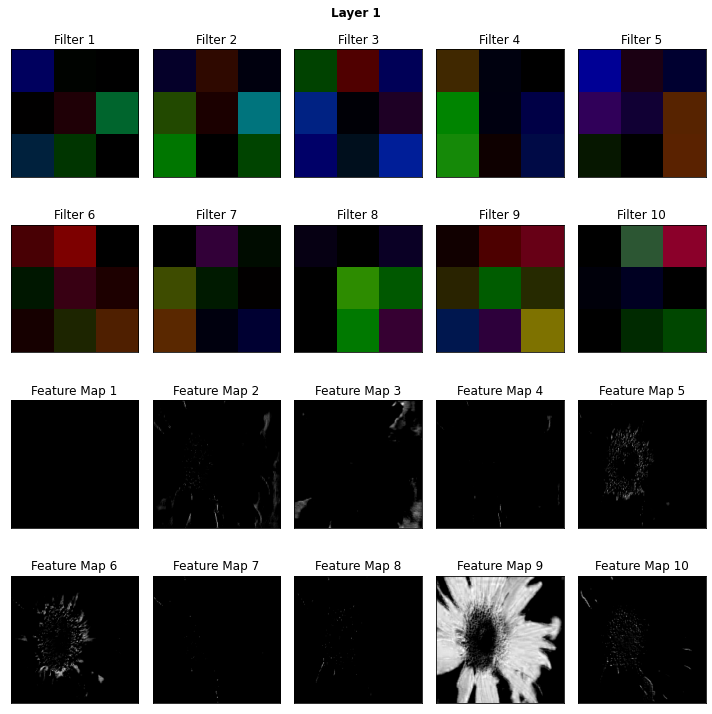

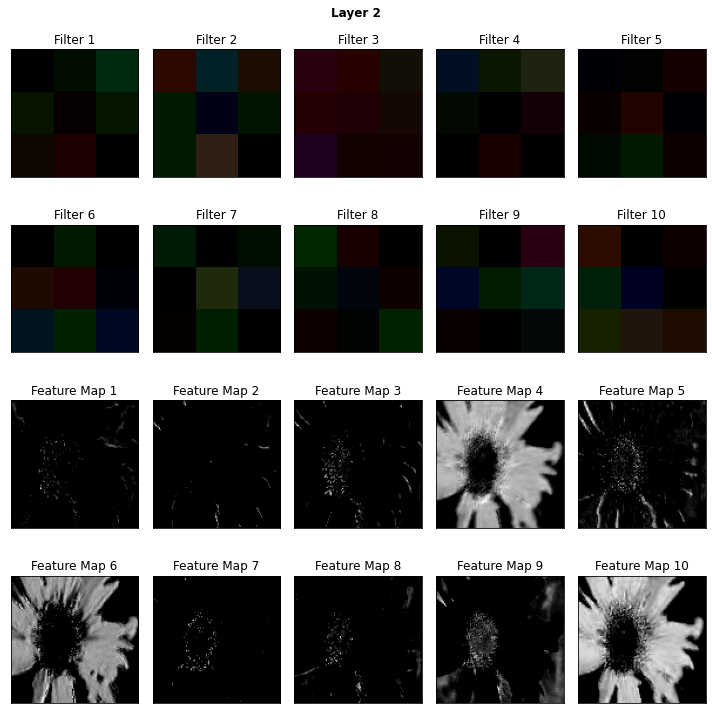

In [ ]:
def PlotFilters(cnn,input):
  
  def Plot_Image(nrows,ncols,index,IMG,title,gray=True):
    IMG = np.clip(a = IMG, a_min = 0, a_max = 1)
    plt.subplot(nrows,ncols,index)
    if gray:  plt.imshow(IMG,cmap='gray')
    else:     plt.imshow(IMG)
    plt.xticks([]);plt.yticks([])
    plt.title(title)
  
  filter1 = cnn.layers[0].get_weights()[0]
  CL1_model = Model(inputs=cnn.input, outputs=cnn.layers[0].output)
  CL1_output = CL1_model.predict(input.reshape(-1,224,224,3))
  plt.figure(figsize=(10,10))
  plt.suptitle("Layer 1",fontweight="bold",y=1+1e-2)
  for i in range(10):
    IMG = filter1[:,:,:,i]
    Plot_Image(4,5,i+1,IMG,title='Filter '+str(i+1))
    Plot_Image(4,5,i+11,CL1_output[:,:,:,i].reshape(222,222),title='Feature Map '+str(i+1))
  plt.tight_layout()
  plt.show()

  filter2 = cnn.layers[2].get_weights()[0]
  CL2_model = Model(inputs=cnn.input, outputs=cnn.layers[2].output)
  CL2_output = CL2_model.predict(input.reshape(-1,224,224,3))
  plt.figure(figsize=(10,10))
  plt.suptitle("Layer 2",fontweight="bold",y=1+1e-2)
  for i in range(10):
    IMG = filter2[:,:,:,i]
    Plot_Image(4,5,i+1,IMG[:,:,:3],title='Filter '+str(i+1))
    Plot_Image(4,5,i+11,CL2_output[:,:,:,i].reshape(109,109),title='Feature Map '+str(i+1))
  plt.tight_layout()
  plt.show()

print("Butterfly:")
PlotFilters(cnn,img_butterfly_colour)

print("\nKangaroo:")
PlotFilters(cnn,img_kangaroo_colour)

print("\nSunflower:")
PlotFilters(cnn,img_sunflower_colour)

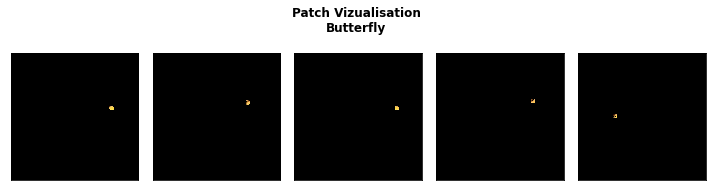

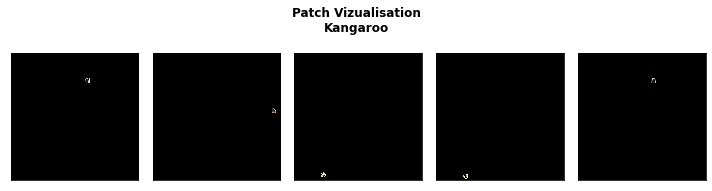

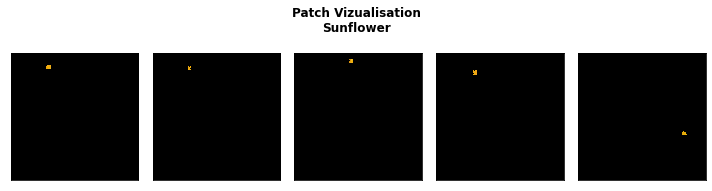

In [ ]:
def Back_Prop(input_image,title):
  input_image = tf.convert_to_tensor(input_image.reshape(-1,224,224,3))
  base_model = cnn
  test_model = Model(inputs=base_model.inputs, outputs=base_model.get_layer('max_pooling2d_1').output)

  result = base_model(input_image)

  @tf.custom_gradient
  def backpropRelu(x):
      def grad(dy):
          return tf.cast(dy>0,tf.float32)  * tf.cast(x>0,tf.float32) * dy
      return tf.nn.relu(x), grad

  layer_dict = [layer for layer in test_model.layers[1:] if hasattr(layer,'activation')]
  for layer in layer_dict: #replacing vanilla ReLU with custom Relu
      if layer.activation == tf.keras.activations.relu:
          layer.activation = backpropRelu

  def normalize(img):
      img = tf.clip_by_value(img, clip_value_min=0, clip_value_max=1)
      #img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
      return img.numpy()

  def Plot_Image(img,nrow,ncol,index):
    plt.subplot(nrow,ncol,index)
    img_copy = np.zeros(shape=(224,224,3))
    img_copy[img>0] = 1
    img_copy[:,:,0] = img_copy.max(axis=2)
    img_copy[:,:,1] = img_copy.max(axis=2)
    img_copy[:,:,2] = img_copy.max(axis=2)
    
    img = input_image[0]*img_copy
    plt.imshow(img,interpolation='nearest')
    plt.xticks([]);plt.yticks([])


  def findMostActivated(tensor, top = 5): #finds top 5 most activated neurons from tensor size (14,14,512)
      t = np.array(tensor)
      t_flat = t.flatten()
      
      def access_hwd(position): #returns 3D position of neuron from 1D index
          height = (position//64)//54
          width = (position//64)%54
          depth = position - (64*54*height + 64*width)
          return height, width, depth
      
      ind = np.argpartition(t_flat, -top)[-top:] #gets indices of top 5 values from t_flat
      ind = ind[np.argsort(t_flat[ind])][::-1]
      return np.array([access_hwd(i) for i in ind])

  def trackEffect(input_img, Top = 5):
      
      with tf.GradientTape(persistent=True) as tape:
          tape.watch(input_img) #watching input_img. After chain rule, gradient will eventually be against input_img.
          conv = test_model(input_img)[0] #output of last convolutional layer
          most_activated = findMostActivated(conv, top = Top) #top 5 activated neurons
    
          plt.figure(figsize=(10,3)) 
          plt.suptitle('Patch Vizualisation\n'+title,fontweight="bold",y=1+1e-2)   
          ind = 1
          for i in range(Top):
              x,y,z = most_activated[i]
              max_conv = conv[x,y,z]
              grads = tape.gradient(max_conv, input_img)
              Plot_Image(img=normalize(grads[0]),nrow=1,ncol=5,index=ind)
              ind+=1
          plt.tight_layout()
          plt.show()
      return most_activated, conv
  top5_neurons, output = trackEffect(input_image)

Back_Prop(img_butterfly_colour,"Butterfly")
Back_Prop(img_kangaroo_colour,"Kangaroo")
Back_Prop(img_sunflower_colour,"Sunflower")

# **`Q4`**



In [ ]:
#VGG
def vgg19_layer(x_train, y_train, x_val, y_val, x_test, y_test, batch_size,error_th,p,epochs=1e3):

  base_model = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
  base_model.trainable = False
  
  num_classes=3

  flat = Flatten()(base_model.layers[-1].output)
  outputs = Dense(num_classes, activation='softmax')(flat)
  model = keras.Model(base_model.inputs, outputs)
  
  tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  es = EarlyStopping(monitor='loss',mode='min',min_delta = error_th,verbose=1,patience=p)
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  
  # this is only for training purpose
  train_datagen = ImageDataGenerator(rescale = 1/255.0)
  val_datagen   = ImageDataGenerator(rescale = 1/255.0)
  
  x_train1 = train_datagen.flow_from_directory('/content/Group_21/train',target_size = (224, 224),
                                               batch_size = batch_size,class_mode = 'categorical')

  x_val1   = val_datagen.flow_from_directory('/content/Group_21/val',target_size = (224, 224),
                                               batch_size = batch_size,class_mode = 'categorical')

  history = model.fit(x_train1,validation_data=x_val1,epochs=int(epochs), batch_size=batch_size,callbacks=[es])
  
  # this is for prediction purpose
  y_train_pred = model.predict(x_train)
  y_val_pred   = model.predict(x_val)
  y_test_pred  = model.predict(x_test)

  y_train_pred = ohetolabel(y_train_pred)
  y_val_pred   = ohetolabel(y_val_pred)
  y_test_pred  = ohetolabel(y_test_pred)
  
  
  print("No of Epochs =",len(history.history["loss"]))
  plt.figure(figsize=(12.5,8))
  plt.suptitle('VGG19',fontweight="bold",y=1+1e-2)
  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'],marker='.')
  plt.plot(history.history['val_accuracy'],marker='.')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid()
  
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'],marker='.')
  plt.plot(history.history['val_loss'],marker='.')
  plt.title('Model loss') 
  plt.ylabel('Loss') 
  plt.xlabel('Epoch') 
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid()
  plt.tight_layout();plt.show()

  print("Training Accuracy =\t",history.history['accuracy'][-1])
  print("Validation Accuracy =\t",history.history['val_accuracy'][-1])

  #Generate the confusion matrix
  plt.figure(figsize=(12.5,4))
  plt.suptitle('VGG19',fontweight="bold",y=1+1e-2)
  plt.subplot(1,3,1)
  cf_matrix = confusion_matrix(y_train, y_train_pred)
  cf_matrix_plot(cf_matrix,"Training Data")
  
  plt.subplot(1,3,2)
  cf_matrix = confusion_matrix(y_val, y_val_pred)
  cf_matrix_plot(cf_matrix,"Validation Data")

  plt.subplot(1,3,3)
  cf_matrix = confusion_matrix(y_test, y_test_pred)
  cf_matrix_plot(cf_matrix,"Test Data")  
  plt.tight_layout()
  plt.show()

  print("\tTraining Data\t\t\t\tValidation Data\t\t\t\tTest Data")
  print("Accuracy:",end=" ")
  print(np.around(accuracy_score(y_train , y_train_pred),4),end="\t"*4)
  print(np.around(accuracy_score(y_val , y_val_pred),4),end="\t"*5)
  print(np.around(accuracy_score(y_test , y_test_pred),4))

  print("Precision:",end="")
  print(np.around(precision_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
  print(np.around(precision_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
  print(np.around(precision_score(y_test , y_test_pred,average="macro"),4))

  print("Recall:",end="   ")
  print(np.around(recall_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
  print(np.around(recall_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
  print(np.around(recall_score(y_test , y_test_pred,average="macro"),4))

  print("F1-Score:",end=" ")
  print(np.around(f1_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
  print(np.around(f1_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
  print(np.around(f1_score(y_test , y_test_pred,average="macro"),4))

  return base_model,model

80150528/80134624 [==============================] - 1s 0us/step
Found 150 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Epoch 1/100
15/15 [==============================] - 107s 7s/step - loss: 1.0142 - accuracy: 0.6733 - val_loss: 0.1611 - val_accuracy: 0.9000
Epoch 2/100
15/15 [==============================] - 100s 7s/step - loss: 0.0505 - accuracy: 0.9733 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 3/100
15/15 [==============================] - 100s 7s/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 4/100
15/15 [==============================] - 100s 7s/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 4: early stopping
No of Epochs = 4


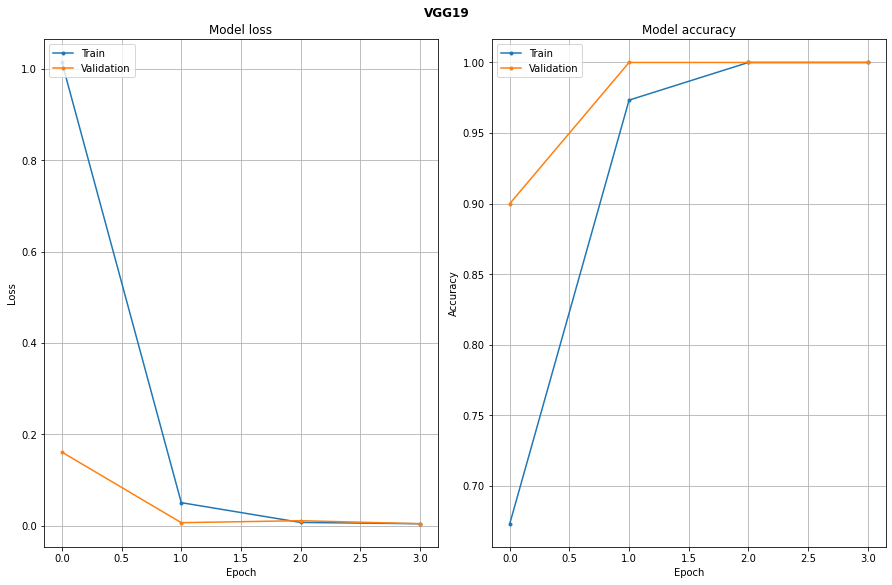

Training Accuracy =	 1.0
Validation Accuracy =	 1.0


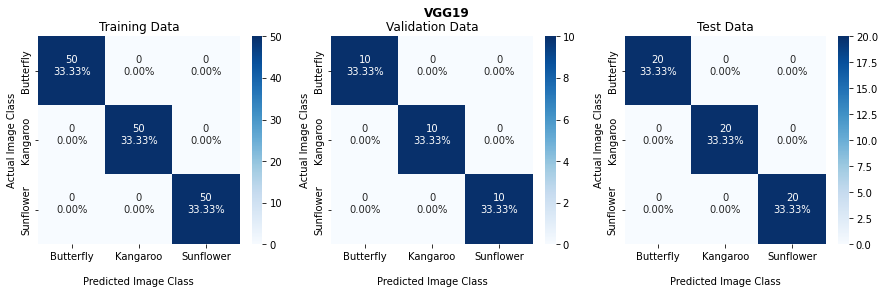

	Training Data				Validation Data				Test Data
Accuracy: 1.0				1.0					1.0
Precision:1.0				1.0					1.0
Recall:   1.0				1.0					1.0
F1-Score: 1.0				1.0					1.0


In [ ]:
error_th = 1e-2
p = 1
batch_size = 10

base_model,VGG_model = vgg19_layer(x_train, y_train, x_val, y_val, x_test, y_test, batch_size,error_th,p,epochs=100)

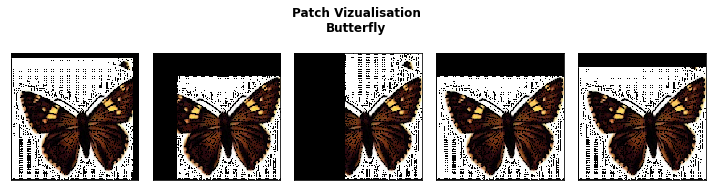

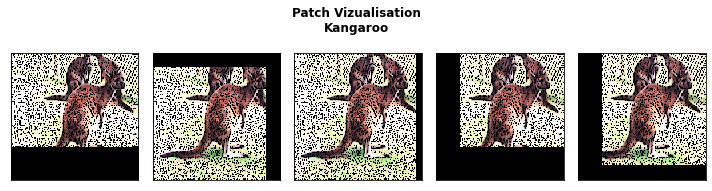

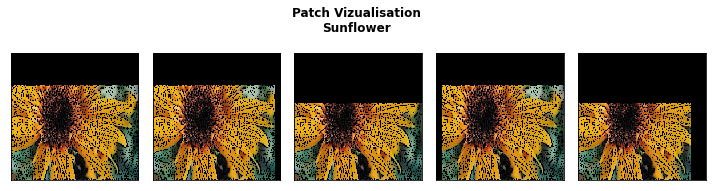

In [ ]:
def Back_Prop(input_image,title):
  input_image = tf.convert_to_tensor(input_image.reshape(-1,224,224,3))
  base_model = VGG19(weights='imagenet')
  test_model = Model(inputs=base_model.inputs, outputs=base_model.get_layer('block5_pool').output)

  result = base_model(input_image)

  @tf.custom_gradient
  def backpropRelu(x):
      def grad(dy):
          return tf.cast(dy>0,tf.float32)  * tf.cast(x>0,tf.float32) * dy
      return tf.nn.relu(x), grad

  layer_dict = [layer for layer in test_model.layers[1:] if hasattr(layer,'activation')]
  for layer in layer_dict: #replacing vanilla ReLU with custom Relu
      if layer.activation == tf.keras.activations.relu:
          layer.activation = backpropRelu

  def normalize(img):
      img = tf.clip_by_value(img, clip_value_min=0, clip_value_max=1)
      #img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
      return img.numpy()

  def Plot_Image(img,nrow,ncol,index):
    plt.subplot(nrow,ncol,index)
    img_copy = np.zeros(shape=(224,224,3))
    img_copy[img>0] = 1
    img_copy[:,:,0] = img_copy.max(axis=2)
    img_copy[:,:,1] = img_copy.max(axis=2)
    img_copy[:,:,2] = img_copy.max(axis=2)

    img = input_image[0]*img_copy
    plt.imshow(img,interpolation='nearest')
    plt.xticks([]);plt.yticks([])

  def findMostActivated(tensor, top = 5): #finds top 5 most activated neurons from tensor size (14,14,512)
      t = np.array(tensor)
      t_flat = t.flatten()
      
      def access_hwd(position): #returns 3D position of neuron from 1D index
          height = (position//512)//7
          width = (position//512)%7
          depth = position - (512*7*height + 512*width)
          return height, width, depth
      
      ind = np.argpartition(t_flat, -top)[-top:] #gets indices of top 5 values from t_flat
      ind = ind[np.argsort(t_flat[ind])][::-1]
      return np.array([access_hwd(i) for i in ind])

  def trackEffect(input_img, Top = 5):
      
      with tf.GradientTape(persistent=True) as tape:
          tape.watch(input_img) #watching input_img. After chain rule, gradient will eventually be against input_img.
          conv = test_model(input_img)[0] #output of last convolutional layer
          most_activated = findMostActivated(conv, top = Top) #top 5 activated neurons
    
          plt.figure(figsize=(10,3)) 
          plt.suptitle('Patch Vizualisation\n'+title,fontweight="bold",y=1+1e-2)   
          ind = 1
          for i in range(Top):
              x,y,z = most_activated[i]
              max_conv = conv[x,y,z]
              grads = tape.gradient(max_conv, input_img)
              Plot_Image(img=normalize(grads[0]),nrow=1,ncol=5,index=ind)
              ind+=1
          plt.tight_layout()
          plt.show()
      return most_activated, conv
  top5_neurons, output = trackEffect(input_image)

Back_Prop(img_butterfly_colour,"Butterfly")
Back_Prop(img_kangaroo_colour,"Kangaroo")
Back_Prop(img_sunflower_colour,"Sunflower")

574726144/574710816 [==============================] - 3s 0us/step


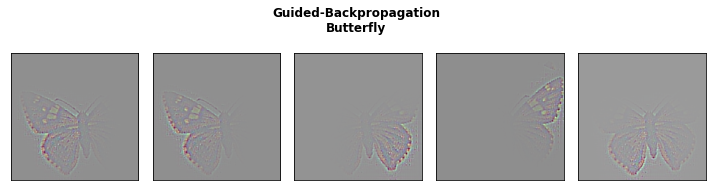

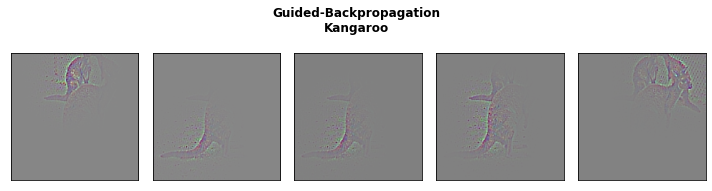

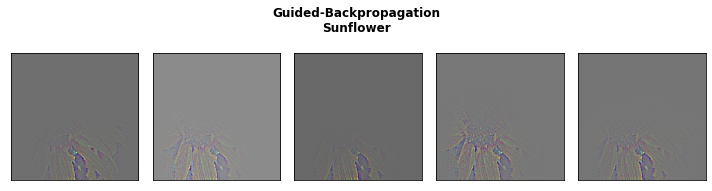

In [ ]:
def Back_Prop(input_image,title):
  input_image = tf.convert_to_tensor(input_image.reshape(-1,224,224,3))
  base_model = VGG19(weights='imagenet')
  test_model = Model(inputs=base_model.inputs, outputs=base_model.get_layer('block5_conv4').output)

  result = base_model(input_image)
  #print(decode_predictions(result.numpy()))

  @tf.custom_gradient
  def backpropRelu(x):
      def grad(dy):
          return tf.cast(dy>0,tf.float32)  * tf.cast(x>0,tf.float32) * dy
      return tf.nn.relu(x), grad

  layer_dict = [layer for layer in test_model.layers[1:] if hasattr(layer,'activation')]
  for layer in layer_dict: #replacing vanilla ReLU with custom Relu
      if layer.activation == tf.keras.activations.relu:
          layer.activation = backpropRelu

  def normalize(img):
      img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
      return img

  def Plot_Image(img,nrow,ncol,index):
    plt.subplot(nrow,ncol,index)
    plt.imshow(img)
    plt.xticks([]);plt.yticks([])

  def findMostActivated(tensor, top = 5): #finds top 5 most activated neurons from tensor size (14,14,512)
      t = np.array(tensor)
      t_flat = t.flatten()
      
      def access_hwd(position): #returns 3D position of neuron from 1D index
          height = (position//512)//14
          width = (position//512)%14
          depth = position - (512*14*height + 512*width)
          return height, width, depth
      
      ind = np.argpartition(t_flat, -top)[-top:] #gets indices of top 5 values from t_flat
      ind = ind[np.argsort(t_flat[ind])][::-1]
      return np.array([access_hwd(i) for i in ind])

  def trackEffect(input_img, Top = 5):
      
      with tf.GradientTape(persistent=True) as tape:
          tape.watch(input_img) #watching input_img. After chain rule, gradient will eventually be against input_img.
          conv = test_model(input_img)[0] #output of last convolutional layer
          most_activated = findMostActivated(conv, top = Top) #top 5 activated neurons
    
          plt.figure(figsize=(10,3)) 
          plt.suptitle('Guided-Backpropagation\n'+title,fontweight="bold",y=1+1e-2)   
          ind = 1
          for i in range(Top):
              x,y,z = most_activated[i]
              max_conv = conv[x,y,z]
              grads = tape.gradient(max_conv, input_img)
              Plot_Image(img=normalize(grads[0]),nrow=1,ncol=5,index=ind)
              ind+=1
          plt.tight_layout()
          plt.show()
      return most_activated, conv
  top5_neurons, output = trackEffect(input_image)

Back_Prop(img_butterfly_colour,"Butterfly")
Back_Prop(img_kangaroo_colour,"Kangaroo")
Back_Prop(img_sunflower_colour,"Sunflower")